# Lab4: Quantize DeiT

### Setup

In [1]:
# install the newest version of torch, torchvision, and timm
#!pip3 uninstall --yes torch torchaudio torchvision torchtext torchdata timm
#!pip3 install torch torchaudio torchvision torchtext torchdata timm

In [1]:
import numpy as np
import torch
from torch import nn
import os
from tqdm.auto import tqdm

from torchvision import datasets, transforms
from timm.data import create_transform
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torch.utils.data import DataLoader

from torch.export import export, ExportedProgram
from torchvision.models.mobilenetv2 import MobileNet_V2_Weights
from torch._export import capture_pre_autograd_graph
from torch.ao.quantization.quantize_pt2e import convert_pt2e, prepare_pt2e, prepare_qat_pt2e
from torch.ao.quantization.quantizer.xnnpack_quantizer import (
    get_symmetric_quantization_config,
    XNNPACKQuantizer,
)
from matplotlib import pyplot as plt

def evaluate_model(model, data_loader, device):
    # model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy}%')
    return accuracy

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')


torch.cuda.is_available()

/home/aa35037123/miniconda3/envs/lab4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
def data_loader_to_list(data_loader):

    new_data_loader = []

    for i, data in enumerate(data_loader):
        if i >= 256:
            break
        new_data_loader.append(data)

    return new_data_loader

In [3]:
def build_dataset_CIFAR100(is_train, data_path):
    transform = build_transform(is_train)
    dataset = datasets.CIFAR100(data_path, train=is_train, transform=transform, download=True)
    nb_classes = 100
    return dataset, nb_classes

def build_transform(is_train):
    input_size = 224
    eval_crop_ratio = 1.0

    resize_im = input_size > 32
    if is_train:
        # this should always dispatch to transforms_imagenet_train
        transform = create_transform(
            input_size=input_size,
            is_training=True,
            color_jitter=0.3,
            auto_augment='rand-m9-mstd0.5-inc1',
            interpolation='bicubic',
            re_prob=0.0,
            re_mode='pixel',
            re_count=1,
        )
        if not resize_im:
            # replace RandomResizedCropAndInterpolation with
            # RandomCrop
            transform.transforms[0] = transforms.RandomCrop(
                input_size, padding=4)
        return transform

    t = []
    if resize_im:
        size = int(input_size / eval_crop_ratio)
        t.append(
            transforms.Resize(size, interpolation=3),  # to maintain same ratio w.r.t. 224 images
        )
        t.append(transforms.CenterCrop(input_size))

    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD))
    return transforms.Compose(t)

def prepare_data(batch_size):
    train_set, nb_classes = build_dataset_CIFAR100(is_train=True, data_path='./data')
    test_set, _ = build_dataset_CIFAR100(is_train=False, data_path='./data')

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader, test_loader, nb_classes

def train_one_epoch(model, criterion, optimizer, data_loader, device):

    cnt = 0

    for image, target in tqdm(data_loader):
        cnt += 1
        image, target = image.to(device), target.to(device)
        output = model(image)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return

## Part1: Simple Quantization Pipeline (0%)

Below is a naive pipeline of quantizing DeiT-S. You may need to modify the pipeline or build your own later on.

[**use_reference_representation=False** in **convert_pt2e()** represents fake quant (matmul using fp32).](https://pytorch.org/tutorials/prototype/pt2e_quant_ptq_static.html#convert-the-calibrated-model-to-a-quantized-model)

However when the variable is set to True, the execution speed becomes extremely slow.

In this lab, it is just fine to set **use_reference_representation=False**.

In [4]:
def quantize_ptq_model(model: nn.Module, data_loader, per_channel=False) -> None:
    _dummy_input_data = (next(iter(data_loader))[0],)
    model.eval()
    model = capture_pre_autograd_graph(model, _dummy_input_data)

    quantizer = XNNPACKQuantizer()
    quantization_config = get_symmetric_quantization_config(is_per_channel=per_channel, is_qat=False)
    quantizer.set_global(quantization_config)
    # prepare_pt2e folds BatchNorm operators into preceding Conv2d operators, and inserts observers in appropriate places in the model.
    model = prepare_pt2e(model, quantizer)

    # model(*_dummy_input_data)
    #get 128 input data for calibration
    for i, (image, _) in enumerate(data_loader):
        if i >= 128:
            break
        model(image)

    model = convert_pt2e(model, use_reference_representation=False)

    return model

In [6]:
batch_size = 1
model = torch.load('deit3_small_patch16_224_0.9099.pth', map_location='cpu')
train_loader, test_loader, nb_classes = prepare_data(batch_size)

simple_test_loader = data_loader_to_list(test_loader)

# evaluate before quantization
print('Before quantization:')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print_size_of_model(model)
# evaluate_model(model, test_loader, device) # acc: 90.99%
evaluate_model(model, simple_test_loader, device) # for fast testing purpose, this is not the real accuracy

# quantize model
print('Quantizing model...')
model.cpu()
quantized_model = quantize_ptq_model(model, train_loader, per_channel=False)
torch.ao.quantization.move_exported_model_to_eval(quantized_model)

# after quantization
print('After quantization:')
print_size_of_model(quantized_model)
# evaluate_model(quantized_model, test_loader, device) # acc: 82.51%
evaluate_model(quantized_model, simple_test_loader, device) # for fast testing purpose, this is not the real accuracy

Files already downloaded and verified
Files already downloaded and verified
Before quantization:
Device: cuda:0
Size (MB): 86.903222


100%|██████████| 256/256 [00:02<00:00, 116.13it/s]


Accuracy of the model on the test images: 93.75%
Quantizing model...
After quantization:
Size (MB): 21.938609


100%|██████████| 256/256 [00:04<00:00, 51.82it/s]

Accuracy of the model on the test images: 86.328125%


86.328125

#### To export and save quantized model

In [7]:
quantized_model_path = "deits_quantized.pth"
quantized_model.cpu()

cpu_example_inputs = (next(iter(train_loader))[0], )
quantized_ep = torch.export.export(quantized_model, cpu_example_inputs)
torch.export.save(quantized_ep, quantized_model_path)

#### To load back the exported quantized model

In [8]:
loaded_quantized_ep = torch.export.load(quantized_model_path)
loaded_quantized_model = loaded_quantized_ep.module()
# acc = evaluate_model(loaded_quantized_model, test_loader, device)
acc = evaluate_model(quantized_model, simple_test_loader, device) # for fast testing purpose, this is not the real accuracy

100%|██████████| 256/256 [00:03<00:00, 73.71it/s]

Accuracy of the model on the test images: 85.9375%


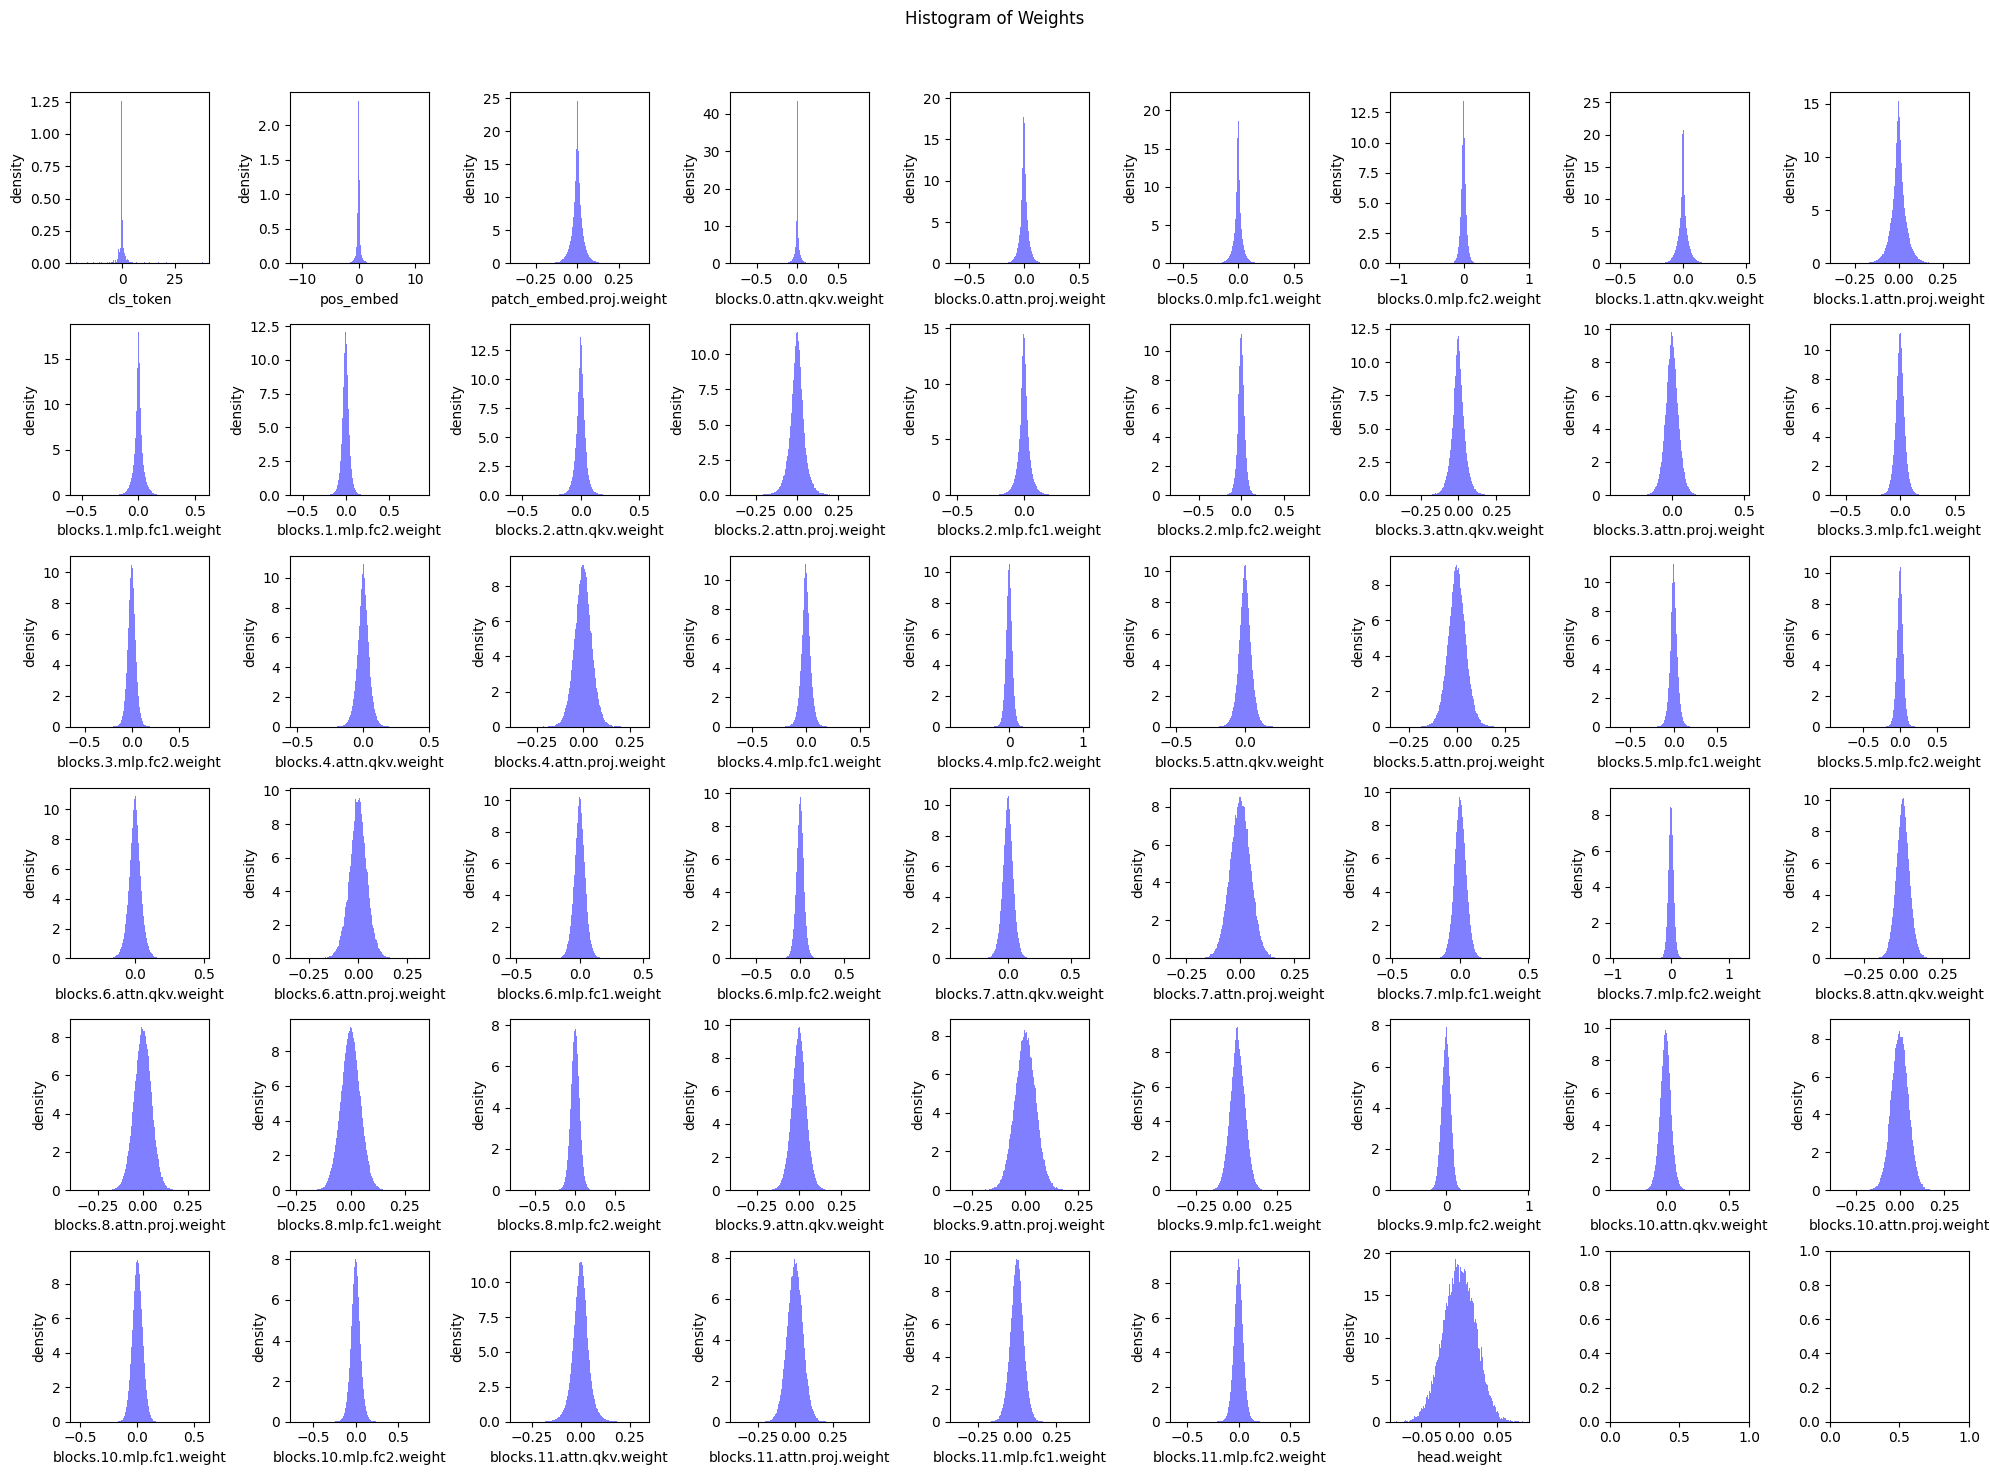

In [9]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(6, 9, figsize=(20, 15))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

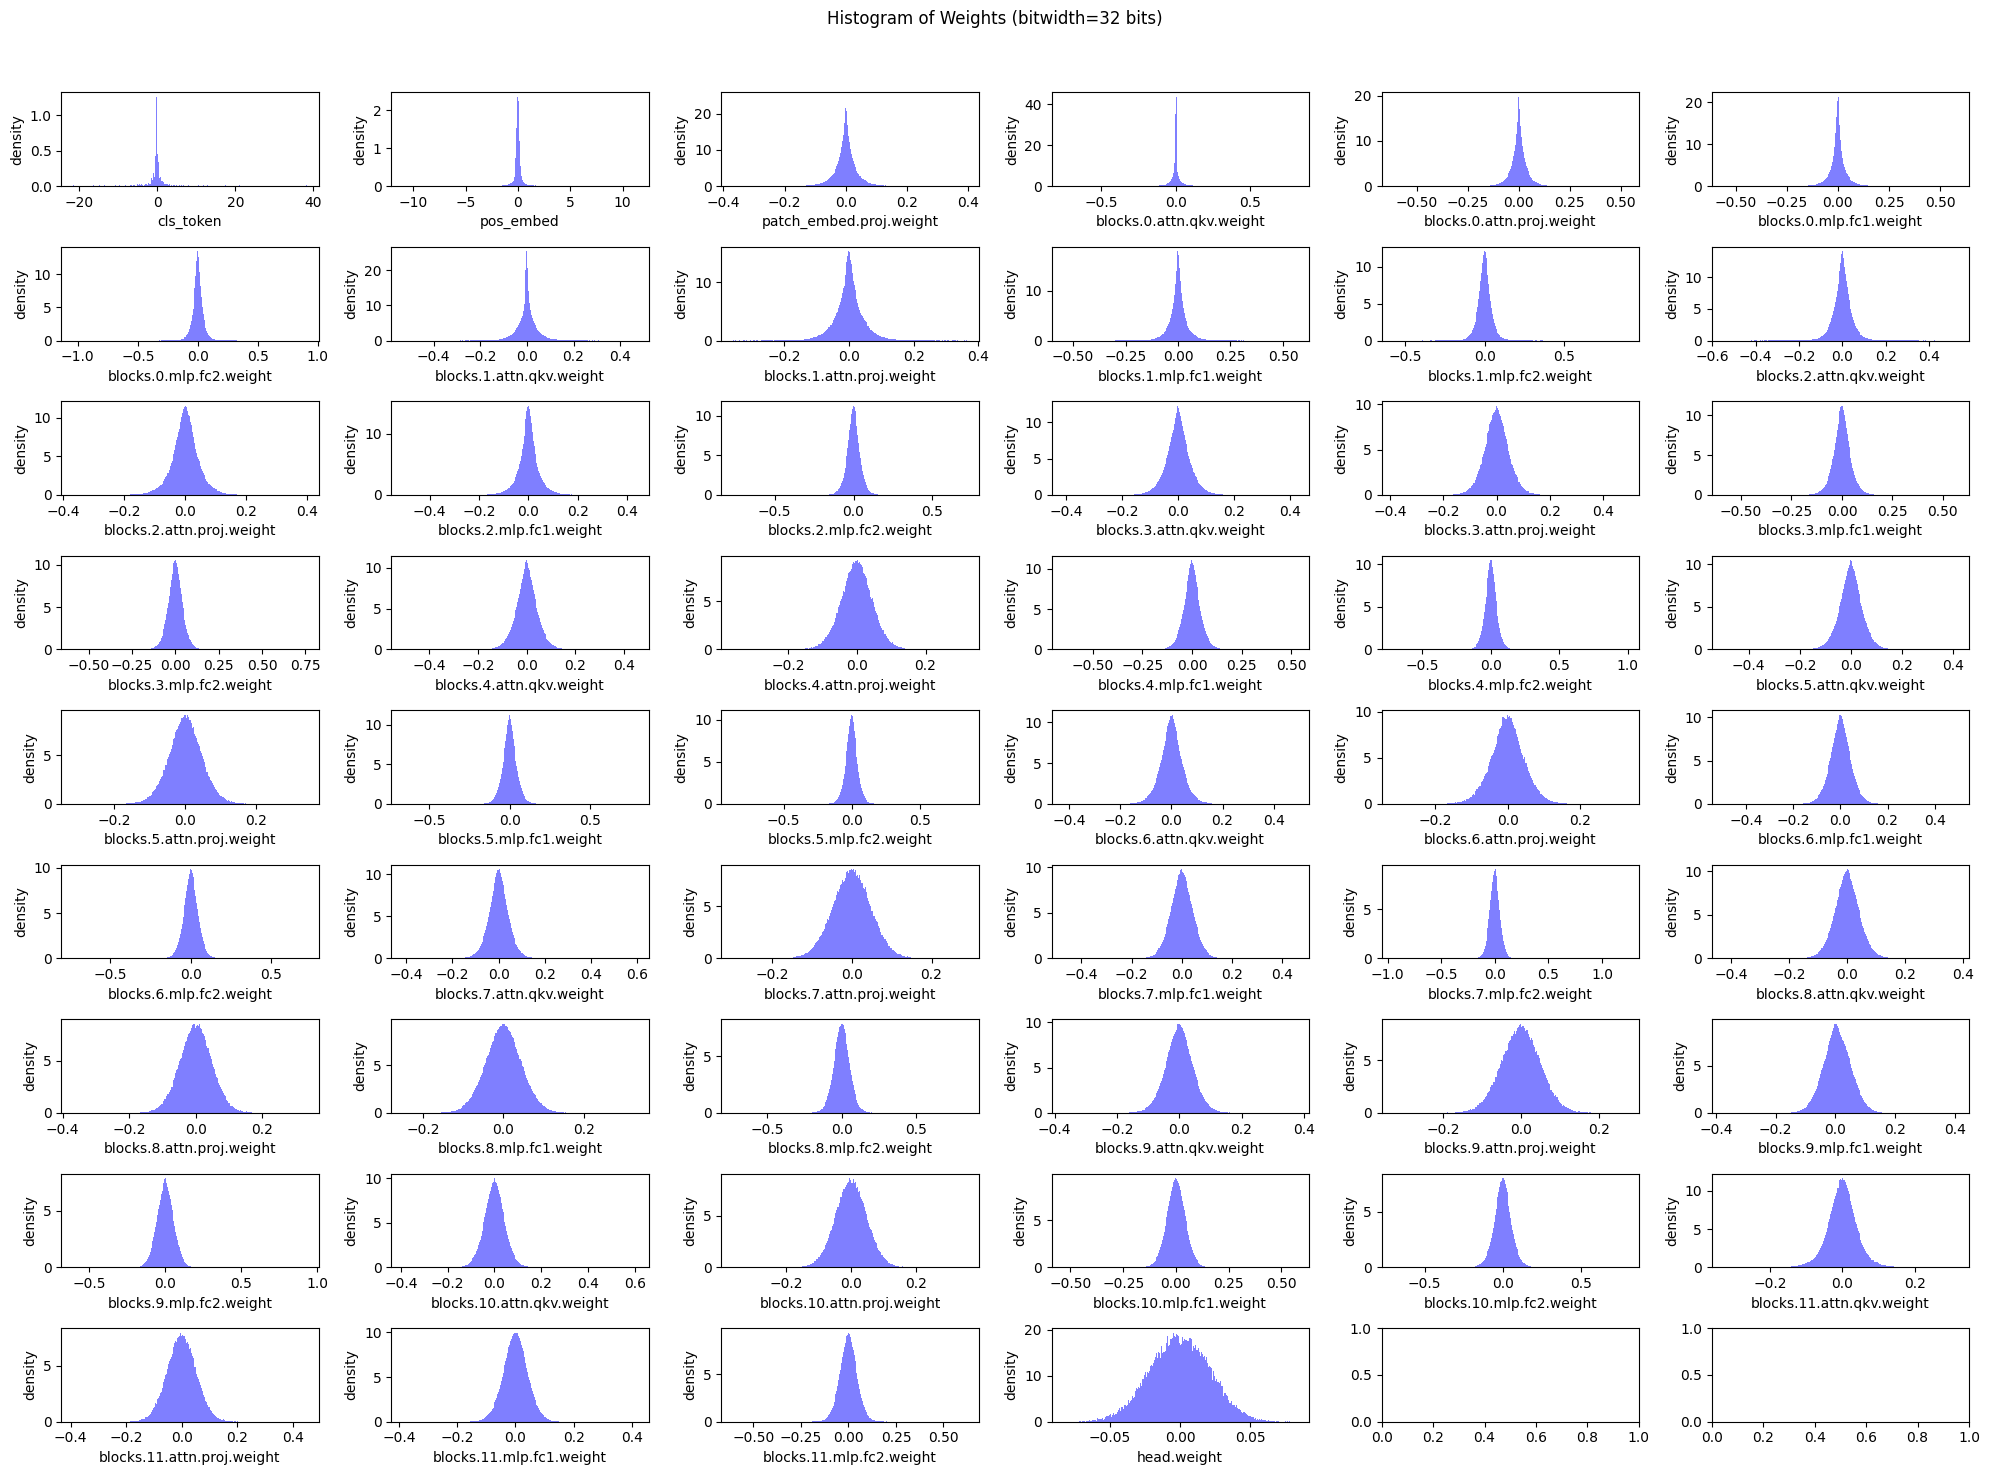

In [7]:
def get_quantized_range(bitwidth):
    quantized_max = (1 << (bitwidth - 1)) - 1
    quantized_min = -(1 << (bitwidth - 1))
    return quantized_min, quantized_max

def plot_quantized_weight_distribution(model, bitwidth=32):
    # bins = (1 << bitwidth) if bitwidth <= 8 else 256
    if bitwidth <= 8:
        qmin, qmax = get_quantized_range(bitwidth)
        bins = np.arange(qmin, qmax + 2)
        align = 'left'
    else:
        bins = 256
        align = 'mid'
    fig, axes = plt.subplots(9,6, figsize=(20, 15))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                    align=align, color = 'blue', alpha = 0.5,
                    edgecolor='black' if bitwidth <= 4 else None)
            if bitwidth <= 4:
                quantized_min, quantized_max = get_quantized_range(bitwidth)
                ax.set_xticks(np.arange(start=quantized_min, stop=quantized_max+1))
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_quantized_weight_distribution(model)

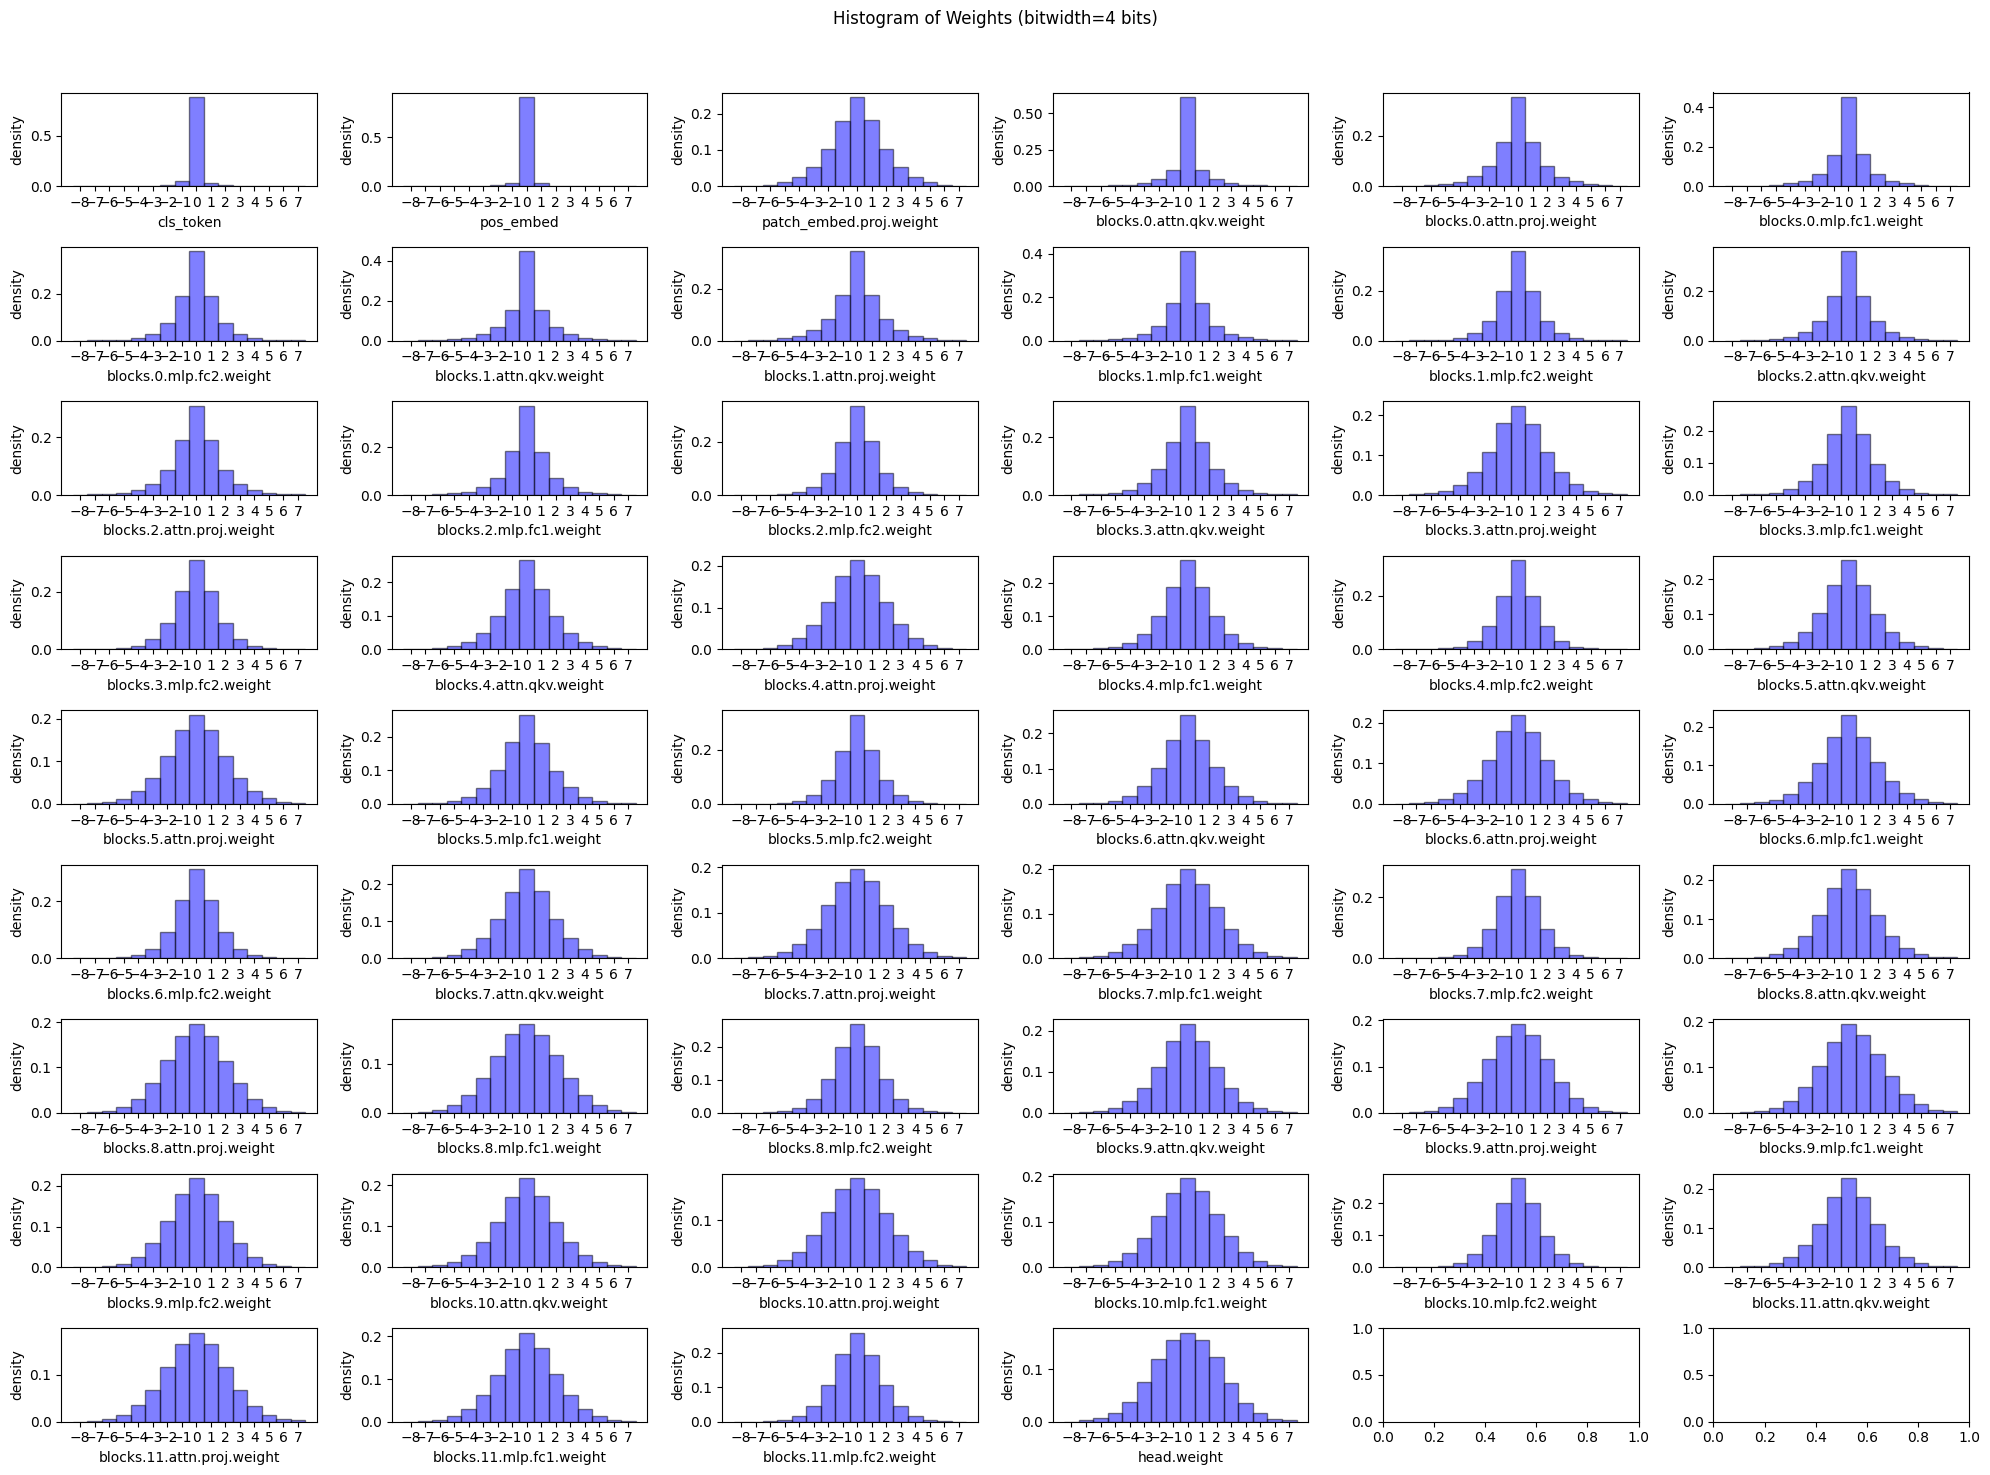

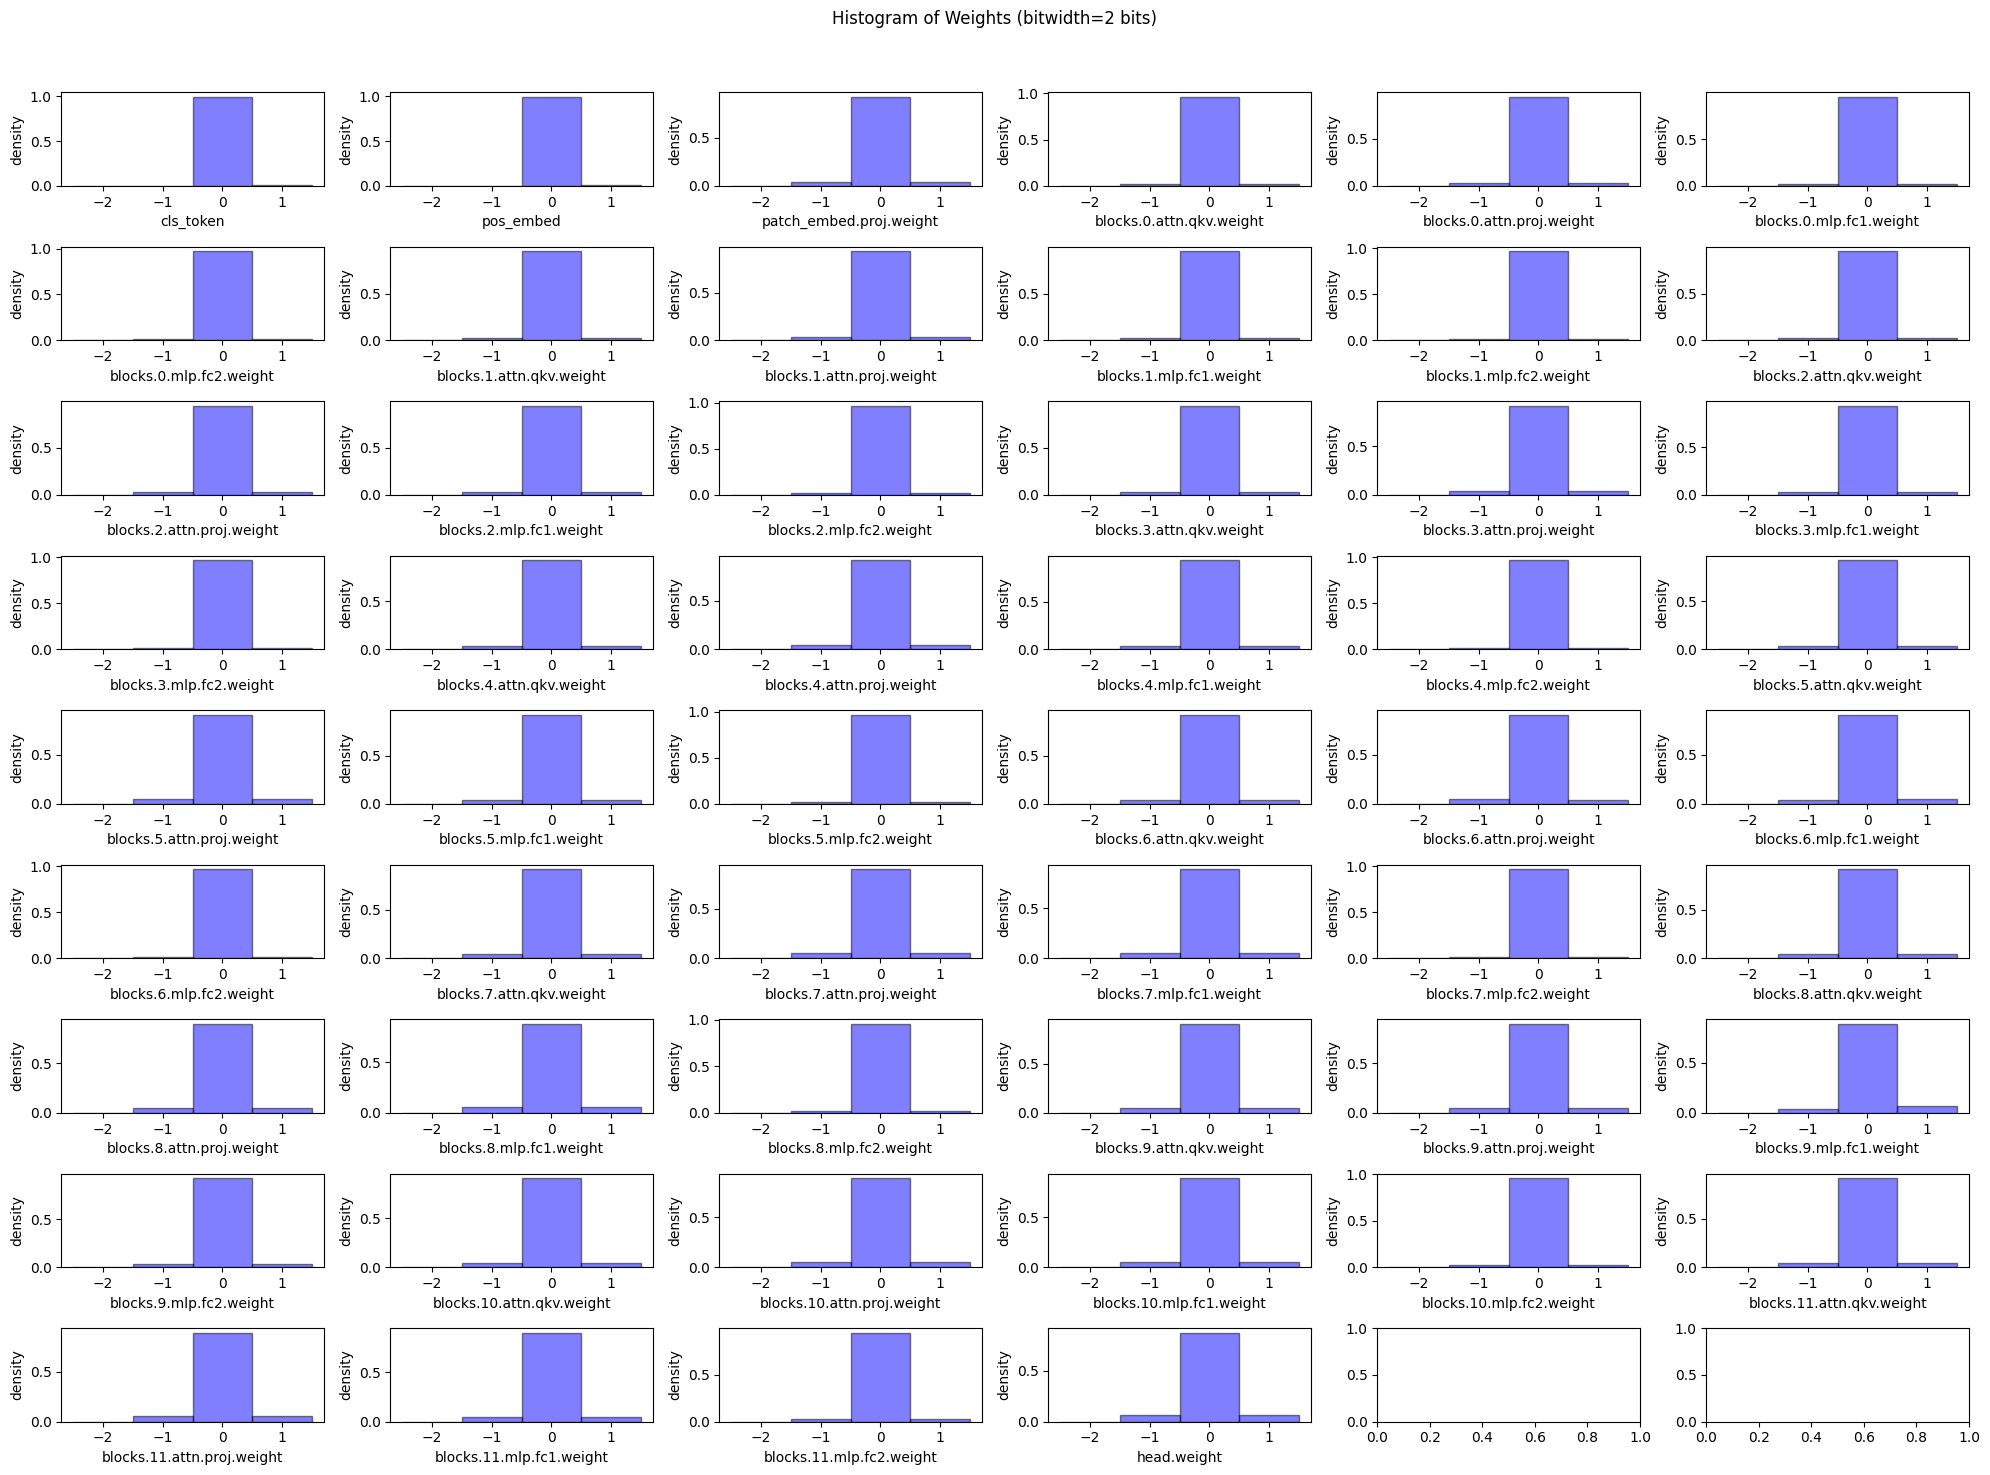

In [9]:
def get_quantization_scale_for_weight(weight, bitwidth):
    """
    get quantization scale for single tensor of weight
    :param weight: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [integer] quantization bit width
    :return:
        [floating scalar] scale
    """
    # we just assume values in weight are symmetric
    # we also always make zero_point 0 for weight
    fp_max = max(weight.abs().max().item(), 5e-7)
    _, quantized_max = get_quantized_range(bitwidth)

    ############### YOUR CODE STARTS HERE ###############
    # hint: one line of code for calculating scale
    scale = fp_max / quantized_max
    ############### YOUR CODE ENDS HERE #################

    return scale
def linear_quantize(fp_tensor, bitwidth, scale, zero_point, dtype=torch.int8) -> torch.Tensor:
    """
    linear quantization for single fp_tensor
      from
        fp_tensor = (quantized_tensor - zero_point) * scale
      we have,
        quantized_tensor = int(round(fp_tensor / scale)) + zero_point
    :param tensor: [torch.(cuda.)FloatTensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :param scale: [torch.(cuda.)FloatTensor] scaling factor
    :param zero_point: [torch.(cuda.)IntTensor] the desired centroid of tensor values
    :return:
        [torch.(cuda.)FloatTensor] quantized tensor whose values are integers
    """
    assert(fp_tensor.dtype == torch.float)
    assert(isinstance(scale, float) or
           (scale.dtype == torch.float and scale.dim() == fp_tensor.dim()))
    assert(isinstance(zero_point, int) or
           (zero_point.dtype == dtype and zero_point.dim() == fp_tensor.dim()))

    ############### YOUR CODE STARTS HERE ###############
    # Step 1: scale the fp_tensor
    scaled_tensor = fp_tensor / scale
    # Step 2: round the floating value to integer value
    rounded_tensor = torch.round(scaled_tensor)
    ############### YOUR CODE ENDS HERE #################

    rounded_tensor = rounded_tensor.to(dtype)

    ############### YOUR CODE STARTS HERE ###############
    # Step 3: shift the rounded_tensor to make zero_point 0
    shifted_tensor = rounded_tensor + zero_point
    ############### YOUR CODE ENDS HERE #################

    # Step 4: clamp the shifted_tensor to lie in bitwidth-bit range
    # clamp the shifted_tensor to lie in bitwidth-bit range
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    quantized_tensor = shifted_tensor.clamp_(quantized_min, quantized_max)
    return quantized_tensor
def linear_quantize_weight_per_channel(tensor, bitwidth):
    """
    linear quantization for weight tensor
        using different scales and zero_points for different output channels
    :param tensor: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [torch.(cuda.)Tensor] scale tensor
        [int] zero point (which is always 0)
    """
    dim_output_channels = 0
    # num_output_channels is a list of the number of output channels for each layer
    # ex: tensor.shape = [10, 3, 3, 3] -> num_output_channels = 10
    num_output_channels = tensor.shape[dim_output_channels] 
    # print(f'tensor.shape: {tensor.shape}')
    # print(f'num_output_channels: {num_output_channels}')
    scale = torch.zeros(num_output_channels, device=tensor.device)
    for oc in range(num_output_channels):
        # print(f'oc: {oc}')
        # the meaning is equal to tensor[oc, :, :, :](tensor[oc])
        _subtensor = tensor.select(dim_output_channels, oc)
        _scale = get_quantization_scale_for_weight(_subtensor, bitwidth)
        # _scale is a tensor has the same shape as _subtensor
        # ex: _scale shape = [3, 3, 3]
        scale[oc] = _scale 
    scale_shape = [1] * tensor.dim()
    scale_shape[dim_output_channels] = -1
    # print(f'scale_shape: {scale_shape}')
    scale = scale.view(scale_shape)
    quantized_tensor = linear_quantize(tensor, bitwidth, scale, zero_point=0)
    return quantized_tensor, scale, 0

@torch.no_grad()
def peek_linear_quantization():
    model = torch.load("deit3_small_patch16_224_0.9099.pth")
    for bitwidth in [4, 2]:
        for name, param in model.named_parameters():
            if param.dim() > 1:
                quantized_param, scale, zero_point = \
                    linear_quantize_weight_per_channel(param, bitwidth)
                param.copy_(quantized_param)
        plot_quantized_weight_distribution(model, bitwidth)
        model = torch.load("deit3_small_patch16_224_0.9099.pth")


peek_linear_quantization()

In [12]:
import torch.nn.functional as F
def compare_quantization(model, bitwidth):
    mse_scores = {}
    cosine_similarities = {}

    with torch.no_grad():
        for name, param in model.named_parameters():
            if param.dim() > 1:  # targeting weights, not biases
                original_weights = param.clone()
                quantized_weights, scale, zero_point = linear_quantize_weight_per_channel(param, bitwidth)
                
                # MSE Calculation
                mse = F.mse_loss(original_weights, quantized_weights.float()).item()
                mse_scores[name] = mse
                
                # Cosine Similarity Calculation
                cos_sim = F.cosine_similarity(
                    original_weights.view(-1), 
                    quantized_weights.view(-1), 
                    dim=0
                ).item()
                cosine_similarities[name] = cos_sim

                # Replace the original weights with quantized versions for visualization
                param.data.copy_(quantized_weights.float())

    return mse_scores, cosine_similarities

model = torch.load("deit3_small_patch16_224_0.9099.pth", map_location='cpu')
bitwidth = 4
mse, cosine = compare_quantization(model, bitwidth)
results = {'MSE': mse, 'Cosine Similarity': cosine}
print(f"Results for bitwidth {bitwidth}: MSE and Cosine Similarity calculated.")
print(results)

Results for bitwidth 4: MSE and Cosine Similarity calculated.
{'MSE': {'cls_token': 8.926076889038086, 'pos_embed': 0.1858094185590744, 'patch_embed.proj.weight': 3.747683525085449, 'blocks.0.attn.qkv.weight': 1.8097914457321167, 'blocks.0.attn.proj.weight': 2.9489736557006836, 'blocks.0.mlp.fc1.weight': 2.36118221282959, 'blocks.0.mlp.fc2.weight': 2.0464351177215576, 'blocks.1.attn.qkv.weight': 2.4256577491760254, 'blocks.1.attn.proj.weight': 2.9970083236694336, 'blocks.1.mlp.fc1.weight': 2.479503631591797, 'blocks.1.mlp.fc2.weight': 2.089571237564087, 'blocks.2.attn.qkv.weight': 2.648634672164917, 'blocks.2.attn.proj.weight': 2.91409969329834, 'blocks.2.mlp.fc1.weight': 2.5821940898895264, 'blocks.2.mlp.fc2.weight': 2.1622157096862793, 'blocks.3.attn.qkv.weight': 3.046875, 'blocks.3.attn.proj.weight': 3.9670393466949463, 'blocks.3.mlp.fc1.weight': 3.1931073665618896, 'blocks.3.mlp.fc2.weight': 2.3555173873901367, 'blocks.4.attn.qkv.weight': 3.4722399711608887, 'blocks.4.attn.proj.wei

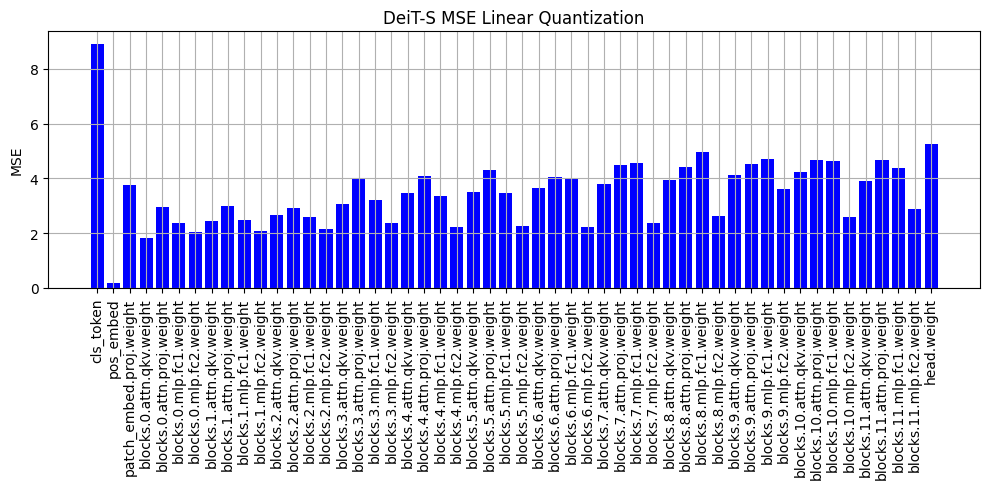

In [38]:
def plot_quantization_results(results):
    # Extracting MSE data
    layers = list(results['MSE'].keys())
    mse_values = list(results['MSE'].values())

    # Creating a single figure for MSE
    plt.figure(figsize=(10, 5))  # Adjusting figure size to better fit one plot
    
    # MSE plot
    plt.bar(layers, mse_values, color='blue')
    plt.title('DeiT-S MSE Linear Quantization')
    plt.ylabel('MSE')
    plt.xticks(rotation=90)  # Rotate labels to improve readability
    plt.grid(True)  # Optional: Adds a grid for easier value estimation
    plt.tight_layout()
    plt.show()

# def plot_quantization_results(results):
#     # Extracting MSE and Cosine Similarity data
#     layers = list(results['MSE'].keys())
#     mse_values = list(results['MSE'].values())
#     cosine_sim_values = list(results['Cosine Similarity'].values())

#     # Creating subplots
#     fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
#     # MSE plot
#     axs[0].bar(layers, mse_values, color='blue')
#     axs[0].set_title('Mean Squared Error (MSE) by Layer')
#     axs[0].set_ylabel('MSE')
#     axs[0].tick_params(axis='x', rotation=90)

#     # Cosine Similarity plot
#     axs[1].bar(layers, cosine_sim_values, color='green')
#     axs[1].set_title('Cosine Similarity by Layer')
#     axs[1].set_ylabel('Cosine Similarity')
#     axs[1].tick_params(axis='x', rotation=90)

#     # Layout adjustments
#     plt.tight_layout()
#     plt.show()

plot_quantization_results(results)

# Below are some tools that may be useful in this lab:

## Profiling Models

The code below profiles your model, and generates a trace file for you to find out what is going on in your model throughout the execution.

The generated trace file will be named *(test_trace_*.json)*, in the same directory as the notebook. To visualize, go to page [chrome://tracing](chrome://tracing) in either Chrome or Edge browser, then upload the trace file.

In [8]:
# profile model
from torch.profiler import profile, record_function, ProfilerActivity

# ## Default way to use profiler
# with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
#     for _ in range(10):
#         a = torch.square(torch.randn(10000, 10000).cuda())

# prof.export_chrome_trace("trace.json")

def torch_profile(model, input_data, device):
  ## With warmup and skip
  # https://pytorch.org/docs/stable/profiler.html

  # Non-default profiler schedule allows user to turn profiler on and off
  # on different iterations of the training loop;
  # trace_handler is called every time a new trace becomes available
  def trace_handler(prof):
    print(prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=-1))
    prof.export_chrome_trace("./test_trace_" + str(prof.step_num) + ".json")

  with torch.profiler.profile(
    activities=[
      torch.profiler.ProfilerActivity.CPU,
      torch.profiler.ProfilerActivity.CUDA,
    ],

    # In this example with wait=1, warmup=1, active=2, repeat=1,
    # profiler will skip the first step/iteration,
    # start warming up on the second, record
    # the third and the forth iterations,
    # after which the trace will become available
    # and on_trace_ready (when set) is called;
    # the cycle repeats starting with the next step
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=2, repeat=1),
    on_trace_ready=trace_handler
    # on_trace_ready=torch.profiler.tensorboard_trace_handler('./log')
    # used when outputting for tensorboard
    ) as p:
      for data in input_data:
        model(data.to(device))
        # send a signal to the profiler that the next iteration has started
        p.step()

In [11]:
dummy_input_data = [next(iter(test_loader))[0] for _ in range(3)]
device = torch.device("cpu")

# profile quantized model
torch_profile(loaded_quantized_model, dummy_input_data, device)

STAGE:2024-05-13 16:21:02 8863:8863 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-05-13 16:21:02 8863:8863 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-05-13 16:21:02 8863:8863 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        ProfilerStep*        11.00%      15.661ms        99.98%     142.360ms      71.180ms             2  
                                             aten::to         3.51%       4.992ms        13.94%      19.843ms      12.910us          1537  
            quantized_decomposed::quantize_per_tensor         6.49%       9.240ms        29.98%      42.684ms     241.153us           177  
                                            aten::mul        14.03%      19.978ms        17.74%      25.265ms      52.966us           477  
                    

## To obtain specific model layers

In [16]:
def match_string(string, match_list, match_prefix=False, match_suffix=False):
    if match_prefix:
        return any(string.startswith(s) for s in match_list)
    elif match_suffix:
        return any(string.endswith(s) for s in match_list)
    else:
        return any(s in string for s in match_list)

def get_model_layers(model, match_names=None, match_types=None, prefix=''):
    matching_layers = []
    for name, module in model.named_modules():
        if match_names is None or match_string(name, match_names):
            if match_types is None or match_string(type(module).__name__, match_types):
                matching_layers.append((f'{prefix}{name}', module))
    return matching_layers

layer_names = [f'blocks.0.attn.qkv', f'blocks.0.mlp.fc1', f'blocks.0.mlp.fc2']
block0_layers = get_model_layers(model, match_names=layer_names, match_types=['Linear'])

print(block0_layers)

[('blocks.0.attn.qkv', Linear(in_features=384, out_features=1152, bias=True)), ('blocks.0.mlp.fc1', Linear(in_features=384, out_features=1536, bias=True)), ('blocks.0.mlp.fc2', Linear(in_features=1536, out_features=384, bias=True))]


## To capture the output of each layer


In [17]:
class HookHandler:
    def __init__(self):
        self.handlers = []

    def __del__(self):
        self.remove_hooks()

    def _generate_hook(self, apply_func, key, layer_data_dict: dict):
        def hook_fn(model, input, output):
            nonlocal layer_data_dict
            layer_data_dict[key] = apply_func(
                output, layer_data_dict.get(key, None))
        return hook_fn

    def _bind_hooks(self, apply_layers, apply_func, layer_data_dict: dict):
        for name, module in apply_layers:
            hook_fn = self._generate_hook(apply_func, name, layer_data_dict)
            self.handlers.append(module.register_forward_hook(hook_fn))

    def create_hooks(self, apply_layers, apply_func, layer_data_dict: dict):
        self._bind_hooks(apply_layers, apply_func, layer_data_dict)

    def remove_hooks(self):
        for handle in self.handlers:
            handle.remove()
        self.handlers = []

    def add_hooks_to_graph_module(self, graph_module, hook_fn, layers_of_interest):
        """Add hooks to specific nodes in the graph based on layer of interest."""
        for node in graph_module.graph.nodes:
            # print("In a node")
            if node.op == 'call_module' and node.target in layers_of_interest:
                print(f'IN add hooks')
                sub_module = dict(graph_module.named_modules())[node.target]
                sub_module.register_forward_hook(hook_fn(node.target))

# Create a simple hook function to capture outputs
def capture_outputs(layer_name, outputs_dict):
    def hook(module, input, output):
        print(f"Hook activated for: {layer_name}")
        outputs_dict[layer_name] = output.detach()
    return hook

def absmax(data, axis=None):
    p_data = data.max(axis=axis)
    n_data = data.min(axis=axis)
    return np.where(abs(p_data) > abs(n_data), p_data, n_data)

def get_flat_act_func(new_val: torch.Tensor, _):
    return new_val.cpu().detach().numpy().flatten()


def get_act_func(new_val: torch.Tensor, _):
    return new_val.cpu().detach().numpy()


def get_avg_act_func(new_val: torch.Tensor, existing_val):
    if existing_val is None:
        avg = new_val.cpu().detach().numpy().sum(axis=0) / total_cnt
        total_cnt = new_val.shape[0]

    else:
        total_cnt, avg = existing_val.get("total_cnt"), existing_val.get("value")
        avg = (avg * total_cnt + new_val.cpu().detach().numpy().sum(axis=0)) / (total_cnt + new_val.shape[0])
        total_cnt += new_val.shape[0]

    return {"total_cnt": total_cnt, "value": avg}

def get_absmax_act_func(new_val: torch.Tensor, existing_val):
    new_absmax = absmax(new_val.cpu().detach().numpy(), axis=0)
    if existing_val is None:
        value = new_absmax
    else:
        value = absmax(np.stack([existing_val, new_absmax], axis=0), axis=0)
    return value

In [15]:
# initialize HookHandler and the dictionary to store the outputs
handler = HookHandler()
layer_outputs = {}

# get the layers you want to record
layer_names = [f'blocks.0.attn.qkv', f'blocks.0.mlp.fc1', f'blocks.0.mlp.fc2']
block0_layers = get_model_layers(model, match_names=layer_names, match_types=['Linear'])

# create hooks for the layers (<layers>, <hook function>, <dictionary to store the outputs>)
handler.create_hooks(block0_layers, get_act_func, layer_outputs)

model = model.to(device)
model.eval()
# calibrate the model and record the outputs
with torch.autocast(device_type="cuda"):
    for i, (image, _) in enumerate(train_loader):
        if i >= 128: break
        image = image.to(device)
        model(image)

# remove the hooks
handler.remove_hooks()

print(layer_outputs)

NameError: name 'get_model_layers' is not defined

## To ignore specific layers for quantization:
([xnnpack source code](https://github.com/pytorch/pytorch/blob/main/torch/ao/quantization/quantizer/xnnpack_quantizer.py\), also you can try messing around with the Observer classes)

In [18]:
# Replace functions XNNPackQuantizer uses for annotation.

def get_module_names(name):
    names = name.split(".")
    return [".".join(names[i:]) for i in reversed(range(len(names)))]

def parse_string(name):
    if name.startswith("L"): return name[10:]
    split_getattr = name.split(")")
    ig_left = split_getattr[0].split("L['self'].")[-1].split(",")[0]
    ig_right = split_getattr[0].split(", '")[-1][:-1]
    return ig_left + "." + str(ig_right) + split_getattr[1]

def is_name_in_ignore_list(name, IGNORE_LIST):
    return name in IGNORE_LIST

def name_not_in_ignore_list(n, IGNORE_LIST) -> bool:
    nn_module_stack = n.meta.get("nn_module_stack", {})
    names = [n for n, klass in nn_module_stack.values()]
    if len(names) == 0:
        return True

    names = get_module_names(parse_string(names[-1]))
    set1 = set(names)
    set2 = set(IGNORE_LIST)
    # if len(set1.intersection(set2)) == 0:
    #     print("DEBUG: ", names)
    return len(set1.intersection(set2)) == 0

def get_module_name_filter(module_name: str, IGNORE_LIST):
    def module_name_filter(n) -> bool:
        nn_module_stack = n.meta.get("nn_module_stack", {})
        names = [n for n, klass in nn_module_stack.values()]
        if len(names) == 0:
            return False

        names = get_module_names(parse_string(names[-1]))
        return (module_name in names) and name_not_in_ignore_list(n, IGNORE_LIST)
    return module_name_filter


def get_module_type_filter(tp, IGNORE_LIST):
    def module_type_filter(n) -> bool:
        nn_module_stack = n.meta.get("nn_module_stack", {})
        types = [t for _, t in nn_module_stack.values()]
        return (tp in types) and name_not_in_ignore_list(n, IGNORE_LIST)

    return module_type_filter


def get_not_module_type_or_name_filter(
    tp_list, module_name_list, IGNORE_LIST
):
    module_type_filters = [get_module_type_filter(tp) for tp in tp_list]
    module_name_list_filters = [get_module_name_filter(m) for m in module_name_list]

    def not_module_type_or_name_filter(n) -> bool:
        return not any(f(n) for f in module_type_filters + module_name_list_filters) and name_not_in_ignore_list(n, IGNORE_LIST)

    return not_module_type_or_name_filter

class PartialXNNPACKQuantizer(XNNPACKQuantizer): # skips quantizing layers inside the ignore_list
    def __init__(self, ignore_list):
        super().__init__()
        self.ignore_list = ignore_list

    def _annotate_for_static_quantization_config(
        self, model: torch.fx.GraphModule
    ) -> torch.fx.GraphModule:
        print("annotating for static quantization")
        module_name_list = list(self.module_name_config.keys())
        for module_name, config in self.module_name_config.items():
            self._annotate_all_static_patterns(
                model, config, get_module_name_filter(module_name, self.ignore_list)
            )

        tp_list = list(self.module_type_config.keys())
        for module_type, config in self.module_type_config.items():
            self._annotate_all_static_patterns(
                model, config, get_module_type_filter(module_type, self.ignore_list)
            )

        self._annotate_all_static_patterns(
            model,
            self.global_config,
            get_not_module_type_or_name_filter(tp_list, module_name_list, self.ignore_list),
        )
        return model

    def _annotate_for_dynamic_quantization_config(
        self, model: torch.fx.GraphModule
    ) -> torch.fx.GraphModule:
        print("annotating for dynamic quantization")
        module_name_list = list(self.module_name_config.keys())
        for module_name, config in self.module_name_config.items():
            self._annotate_all_dynamic_patterns(
                model, config, get_module_name_filter(module_name, self.ignore_list)
            )

        tp_list = list(self.module_type_config.keys())
        for module_type, config in self.module_type_config.items():
            self._annotate_all_dynamic_patterns(
                model, config, get_module_type_filter(module_type, self.ignore_list)
            )

        self._annotate_all_dynamic_patterns(
            model,
            self.global_config,
            get_not_module_type_or_name_filter(tp_list, module_name_list, self.ignore_list),
        )
        return model

# quantizer = XNNPACKQuantizer()
quantizer = PartialXNNPACKQuantizer(ignore_list=["head"]) # replace XNNPACKQuantizer()

In [19]:
def compare_activations(before, after):
    layer_impact = {}
    for layer in before:
        diff = np.abs(before[layer] - after.get(layer, np.array([])))  # In case some layers are omitted
        layer_impact[layer] = {
            'mean_diff': np.mean(diff),
            'max_diff': np.max(diff),
            'var_diff': np.var(diff)
        }
    return layer_impact



Files already downloaded and verified
Files already downloaded and verified
Layer Name: , Layer Type: VisionTransformer
Layer Name: patch_embed, Layer Type: PatchEmbed
Layer Name: patch_embed.proj, Layer Type: Conv2d
Layer Name: patch_embed.norm, Layer Type: Identity
Layer Name: pos_drop, Layer Type: Dropout
Layer Name: patch_drop, Layer Type: Identity
Layer Name: norm_pre, Layer Type: Identity
Layer Name: blocks, Layer Type: Sequential
Layer Name: blocks.0, Layer Type: Block
Layer Name: blocks.0.norm1, Layer Type: LayerNorm
Layer Name: blocks.0.attn, Layer Type: Attention
Layer Name: blocks.0.attn.qkv, Layer Type: Linear
Layer Name: blocks.0.attn.q_norm, Layer Type: Identity
Layer Name: blocks.0.attn.k_norm, Layer Type: Identity
Layer Name: blocks.0.attn.attn_drop, Layer Type: Dropout
Layer Name: blocks.0.attn.proj, Layer Type: Linear
Layer Name: blocks.0.attn.proj_drop, Layer Type: Dropout
Layer Name: blocks.0.ls1, Layer Type: LayerScale
Layer Name: blocks.0.drop_path1, Layer Type: I

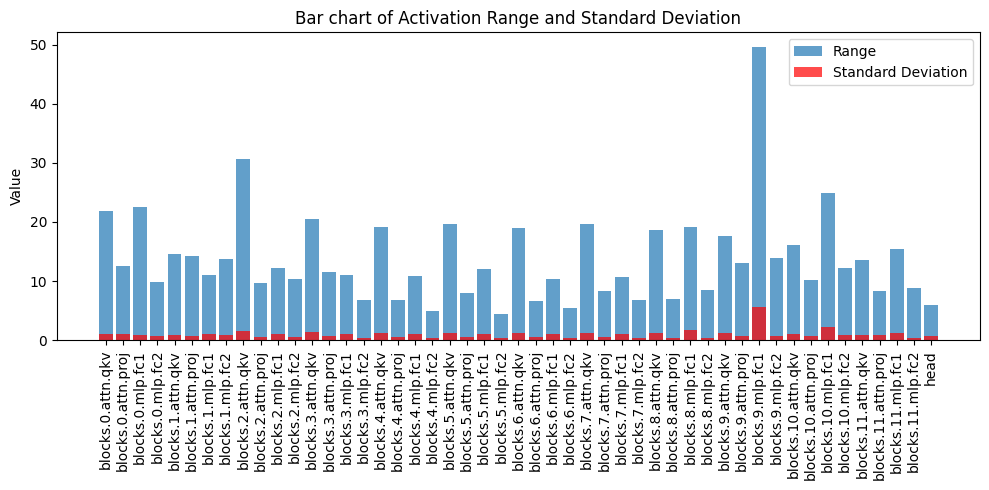

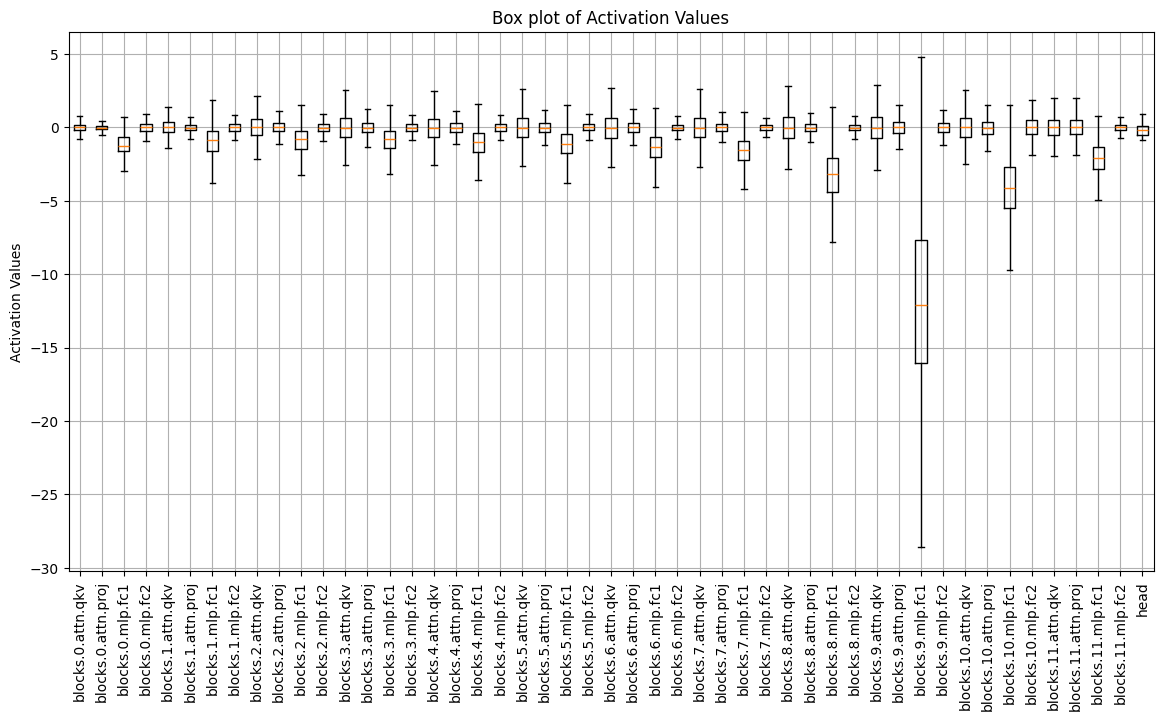

In [31]:
batch_size = 1
model = torch.load('deit3_small_patch16_224_0.9099.pth', map_location='cpu')
train_loader, test_loader, nb_classes = prepare_data(batch_size)
for name, module in model.named_modules():
    print(f'Layer Name: {name}, Layer Type: {type(module).__name__}')
print('###########################################################')

# -------------------------------------------------------------------------
# initialize HookHandler and the dictionary to store the outputs
handler = HookHandler()
layer_outputs = {}

# get the layers you want to record
# layer_names = [f'blocks.0.attn.qkv', f'blocks.0.mlp.fc1', f'blocks.0.mlp.fc2'
# block0_layers = get_model_layers(model, match_names=layer_names, match_types=['Linear'])
# # create hooks for the layers (<layers>, <hook function>, <dictionary to store the outputs>)
# handler.create_hooks(block0_layers, get_act_func, layer_outputs)


layers_of_interest = []

layers_of_interest = [(name, module) for name, module in model.named_modules() if isinstance(module, torch.nn.Linear)]
print(f'layers_of_interest: {layers_of_interest}')
for name, module in layers_of_interest:
    print(f'Layer Name: {name}, Layer Type: {type(module).__name__}')
print(f'layers_of_interest: {layers_of_interest}')
handler.create_hooks(layers_of_interest, get_act_func, layer_outputs)
model.eval()

# calibrate the model and record the outputs
with torch.autocast(device_type="cuda"):
    for i, (image, _) in enumerate(train_loader):
        if i >= 128: break
        model(image)

# remove the hooks
handler.remove_hooks()

print(f'######## Original Model Activation output')
for layer_name, activations in layer_outputs.items():
    print(f"Layer: {layer_name}, Data: {activations}")
    
# Now analyze the activations
activation_ranges = {}
activation_stddevs = {}

for layer_name, act in layer_outputs.items():
    activation_ranges[layer_name] = abs(act.max() - act.min())
    activation_stddevs[layer_name] = act.std()

# Optionally, plot the results for visual analysis
plt.figure(figsize=(10, 5))
plt.bar(activation_ranges.keys(), activation_ranges.values(), alpha=0.7, label='Range')
plt.bar(activation_stddevs.keys(), activation_stddevs.values(), alpha=0.7, label='Standard Deviation', color='r')
plt.ylabel('Value')
plt.title('Bar chart of Activation Range and Standard Deviation')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Box plot for activation distribution
data = [activation.flatten() for activation in layer_outputs.values()]  # Flatten all activations
labels = list(layer_outputs.keys())

plt.figure(figsize=(14, 7))
plt.boxplot(data, labels=labels, showfliers=False) # showfliers=False will not show any outliers
plt.xticks(rotation=90)
plt.title('Box plot of Activation Values')
plt.ylabel('Activation Values')
plt.grid(True)
plt.show()

# # -------------------------------------------------------------------------
# loaded_quantized_ep = torch.export.load(quantized_model_path)
# loaded_quantized_model = loaded_quantized_ep.module()
# # acc = evaluate_model(loaded_quantized_model, test_loader, device)
# # initialize HookHandler and the dictionary to store the outputs
# torch.ao.quantization.move_exported_model_to_eval(loaded_quantized_model)
# handler = HookHandler()
# for name, module in loaded_quantized_model.named_modules():
#     print(f'Layer Name: {name}, Layer Type: {type(module).__name__}')

# quantized_outputs = {}

# apply_layers = [(name, module) for name, module in loaded_quantized_model.named_modules() if isinstance(module, torch.nn.Linear)]  # Adjust based on layer types of interest

# print(f'apply layers: {apply_layers}')
# layers_of_interest = ['blocks_0_attn_qkv_bias', 'blocks_0_mlp_fc1_bias', 'blocks_0_mlp_fc2_bias']  # Adjust based on actual graph node names
# handler.add_hooks_to_graph_module(loaded_quantized_model, lambda name: capture_outputs(name, quantized_outputs), layers_of_interest)
# # move the quantized model to eval mode, equivalent to `m.eval()`
# # calibrate the model and record the outputs
# with torch.no_grad():
#     for i, (image, _) in enumerate(train_loader):
#         if i >= 128: break
#         image = image.to(device)
#         try:
#             loaded_quantized_model(image)
#         except Exception as e:
#             print(f"Error during forward pass: {e}")


# # remove the hooks
# handler.remove_hooks()

# print(f'######## Quantized activation output')
# print("Quantized Model Activations:")
# print(quantized_outputs)
# for name, activation in quantized_outputs.items():
#     print(f"{name}: {activation.shape}")
# print(loaded_quantized_model.graph)

In [35]:
def count_parameters(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)
specific_block = model.blocks[2].attn.qkv

# Now count the parameters in this specific block
num_parameters = count_parameters(specific_block)
print(f'Number of parameters in block.2.attn.qkv: {num_parameters}')

# Print the names and values of the parameters in the specific block
for name, param in specific_block.named_parameters():
    print(f"Parameter Name: {name}")
    print(f"Parameter Shape: {param.shape}")
    print(f"Values: \n{param.data}\n")

Number of parameters in block.2.attn.qkv: 443520
Parameter Name: weight
Parameter Shape: torch.Size([1152, 384])
Values: 
tensor([[ 0.0063, -0.0106, -0.0140,  ...,  0.0205, -0.0360, -0.0524],
        [ 0.0913, -0.0204, -0.0086,  ..., -0.0007,  0.1083,  0.0439],
        [ 0.0351,  0.0394,  0.0126,  ..., -0.0378,  0.0777, -0.0127],
        ...,
        [-0.0192, -0.0195,  0.0785,  ...,  0.0184, -0.0025,  0.0143],
        [ 0.0483, -0.0574,  0.0392,  ..., -0.0046,  0.0525,  0.0453],
        [ 0.0042,  0.0847,  0.0302,  ..., -0.0292, -0.0022,  0.0283]])

Parameter Name: bias
Parameter Shape: torch.Size([1152])
Values: 
tensor([ 0.0967,  0.0199,  0.0437,  ..., -0.0372,  0.0728,  0.0251])

